In [10]:
import sys; sys.path.insert(0, '..')

import pickle
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from experiments.util import load_data

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, activations, Sequential, losses

In [2]:
X_data, y_data = load_data()

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

#### CNN

In [12]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##### Preprocessing

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [28]:
X_train_std = tf.image.per_image_standardization(X_train)
X_val_std = tf.image.per_image_standardization(X_val)

#### Transfer Learning

##### ResNet 50

Ich habe keine GPU, darum fine tune ich die CNN layers gar nicht.
Ich encode einfach die Bilder mit einem auf ImageNet trainierten ResNet 50 und trainieren auf den somit encodeded Bildern eine Logistische Regression.

###### Encoded images

In [29]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
)

In [30]:
for layer in resnet_50.layers:
    layer.trainable = False

model_pre_res = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3), name='input_layer'),
    layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'),
    layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'),
    layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'),
    resnet_50,
    layers.GlobalAveragePooling2D(),
])

print(X_train_std.shape)
print(X_val_std.shape)

X_train_std_pre = model_pre_res.predict(X_train_std[:, :, :, :])
X_val_std_pre = model_pre_res.predict(X_val_std[:, :, :, :])

print(X_train_std_pre.shape)
print(X_val_std_pre.shape)

(37500, 32, 32, 3)
(12500, 32, 32, 3)


2021-09-06 09:39:01.665715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(37500, 2048)
(12500, 2048)


###### Store encoded images

In [ ]:
def wrap(X, y):
    return {
        'images': X,
        'labels': y
    }

with open('../../data/train_res_50_pre.pkl', 'wb') as fo:
    pickle.dump(wrap(X_train_std_pre, y_train_enc), fo)

with open('../../data/val_res_50_pre.pkl', 'wb') as fo:
    pickle.dump(wrap(X_val_std_pre, y_val_enc), fo)

###### Load encoded images

In [ ]:
with open('../../data/train_res_50_pre.pkl', 'rb') as fo:
    data_train_res = pickle.load(fo)
    X_train_std_pre, y_train_enc = data_train_res['images'], data_train_res['labels']

with open('../../data/val_res_50_pre.pkl', 'rb') as fo:
    data_val_res = pickle.load(fo)
    X_val_std_pre, y_val_enc = data_val_res['images'], data_val_res['labels']

###### Mit Logistischer Regression

In [8]:
clf = LogisticRegression()
clf.fit(X_train_std_pre, y_train)

y_train_hat = clf.predict(X_train_std_pre)
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = clf.predict(X_val_std_pre)
print("Val:   ", accuracy_score(y_val_hat, y_val))

/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(37500, 2048)
(12500, 2048)
Train:  0.5617333333333333
Val:    0.55896


###### Mit letzten Layer noch einmal trainiert (entspricht SGDClassifier)

Epoch 1/100
293/293 [==============================] - 1s 2ms/step - loss: 2.2580 - accuracy: 0.4526 - val_loss: 2.2475 - val_accuracy: 0.5217
Epoch 2/100
293/293 [==============================] - 0s 1ms/step - loss: 2.2429 - accuracy: 0.5529 - val_loss: 2.2422 - val_accuracy: 0.5582

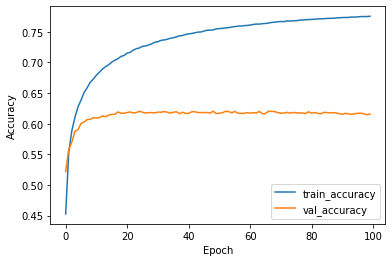

0.61552


In [15]:
from sklearn.preprocessing import StandardScaler

with open('../../data/train_res_50_pre.pkl', 'rb') as fo:
    data_train_res = pickle.load(fo)
    X_train_std_pre, y_train_enc = data_train_res['images'], data_train_res['labels']

with open('../../data/val_res_50_pre.pkl', 'rb') as fo:
    data_val_res = pickle.load(fo)
    X_val_std_pre, y_val_enc = data_val_res['images'], data_val_res['labels']

model_res = Sequential([
    layers.Dense(10, activation=activations.softmax, name='output_layer'),
    layers.Softmax()
])

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)

model_res.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

std = StandardScaler()
X_train_std_pre_std = std.fit_transform(X_train_std_pre)
X_val_std_pre_std = std.transform(X_val_std_pre)

history = model_res.fit(X_train_std_pre_std, y_train_enc, batch_size=128, epochs=100, validation_data=(X_val_std_pre_std, y_val_enc))
plot_history(history)

y_val_hat_prob = model_res.predict(X_val_std_pre_std)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val_enc))